## Import all necessary packages

In [ ]:
!pip3 install emoji
!pip3 install accelerate -U

In [14]:
from transformers import BertTokenizer, BertModel, pipeline, TFDistilBertForSequenceClassification, TFRobertaForSequenceClassification, RobertaTokenizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from transformers import Trainer, TrainingArguments
import torch
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import emoji
import re
from utils import preprocess
import os
from keras.layers import Bidirectional, LSTM, Dense, Dropout
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import pandas as pd

In [34]:
current_path = os.getcwd()

In [35]:
current_path

'/Users/alan/Desktop/BI/Thesis/1st_draft'

## Mount to the GOOGLE DRIVE

In [16]:
!sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!sudo apt-get update -qq 2>&1 > /dev/null
!sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
!google-drive-ocamlfuse

In [ ]:
!sudo apt-get install -qq w3m # to act as web browser
!xdg-settings set default-web-browser w3m.desktop # to set default browser
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package w3m.
(Reading database ... 120885 files and directories currently installed.)
Preparing to unpack .../w3m_0.5.3+git20210102-6ubuntu0.1_amd64.deb ...
Unpacking w3m (0.5.3+git20210102-6ubuntu0.1) ...
Setting up w3m (0.5.3+git20210102-6ubuntu0.1) ...
Processing triggers for man-db (2.10.2-1) ...
/content
/content/drive
/content
/
Access token retrieved correctly.


## Preprocess the data

In [4]:
# read the dataset which I am gonna use to fine tune the model
tweets = pd.read_csv("/Users/alan/Desktop/BI/Thesis/1st_draft/Data/raw.csv")
tweets = tweets[["body","sentiment"]]
tweets["body"] = tweets["body"].apply(preprocess)

In [34]:
import matplotlib.pyplot as plt

#only keep those below 2000
tweets["word_count"] = tweets["body"].apply(lambda x: len(x.split()))
# filtered_tweets = tweets[tweets['body'].apply(lambda x: len(x) <= 500 & len(x) >= 100)]

# plt.hist(np.array(list(map(len,filtered_tweets.body))))
# list(map(len,tweets.body))

In [44]:
tweets.loc[(tweets.word_count >=5) & (tweets.word_count <= 130), ]

,body,sentiment,word_count
0,you see how slow this moves during the day.. ...,Bullish,37
2,she wants to go up,Bullish,5
5,i’m loaded up let’s go !!! rocket rocket rocket,Bullish,9
6,let rsi calm down and then run!,Bullish,7
8,"come on now make a run at 370, break that 360...",Bullish,14
...,...,...,...
2090185,whatever we make in impulse move we tend to g...,Bullish,40
2090186,just nudged above 36220 in the morning!! may ...,Bullish,19
2090187,is approaching a breakout of ascending triang...,Bullish,20
2090189,banking stocks are expected to be in momentum ...,Bullish,32


In [33]:
real = pd.read_csv("/Users/alan/Desktop/BI/Thesis/1st_draft/Data/company_tweet/Tweet.csv")
real.body = real.body.apply(preprocess)

In [46]:
real["word_count"] = real["body"].apply(lambda x: len(x.split()))

real.loc[real.word_count >= 9]
# real.describe()

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,word_count
0,550441509175443456,VisualStockRSRC,1420070457,"lx21 made ,008 on -check it out! learn howtotr...",0,0,1,9
1,550441672312512512,KeralaGuy77,1420070496,insanity of today weirdo massive selling. bid ...,0,0,0,19
3,550442977802207232,ShowDreamCar,1420070807,volkswagen pushes 2014 record recall tally hi...,0,0,1,9
4,550443807834402816,i_Know_First,1420071005,swing trading up to 8.91% return in 14 days sw...,0,0,1,12
5,550443808606126081,aaplstocknews,1420071005,swing trading up to 8.91% return in 14 days sw...,0,0,1,12
...,...,...,...,...,...,...,...,...
3717957,1212159254884433921,QuantWolfLine,1577836261,imagine calling your broker-dealer and wanting...,1,0,1,27
3717958,1212159275637886976,GMGRIFF_79,1577836266,"yearly~ heck of a year.. jan. 2, 1999~around ...",0,0,1,27
3717959,1212159765914079234,TEEELAZER,1577836383,that puuump in the last hour was the eoy eoq e...,1,0,6,46
3717960,1212159838882533376,ShortingIsFun,1577836401,in 2020 i may start tweeting out positive news...,0,0,1,32


(array([1.490712e+06, 7.171700e+05, 2.949940e+05, 1.221830e+05,
        7.733300e+04, 8.388800e+04, 5.949100e+04, 1.607700e+04,
        9.120000e+02, 8.000000e+00]),
 array([ 9. , 14.8, 20.6, 26.4, 32.2, 38. , 43.8, 49.6, 55.4, 61.2, 67. ]),
 <BarContainer object of 10 artists>)

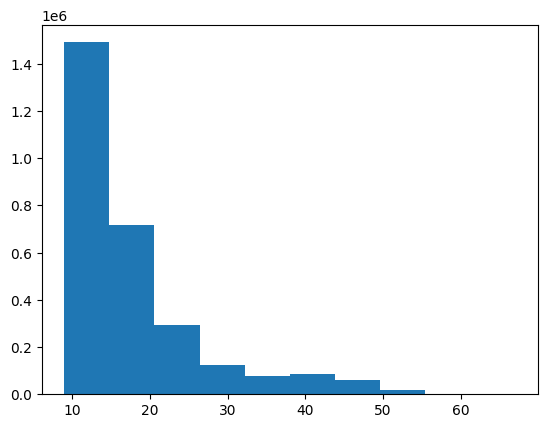

In [52]:
filtered_real = real.loc[(real.word_count >= 9) & (real.word_count <= 130),]

plt.hist(np.array(filtered_real.word_count))

In [1]:
tweets.loc[tweets.sentiment == "Bullish"].sample(50000)
tweets

NameError: name 'tweets' is not defined

In [53]:
ss = pd.read_csv("/Users/alan/Desktop/BI/Thesis/1st_draft/Data/fpb.csv")
ss

,Unnamed: 0,content,sentiment
0,0,"according to gran , the company has no plans t...",0
1,1,"for the last quarter of 2010 , componenta 's n...",1
2,2,"in the third quarter of 2010 , net sales incre...",1
3,3,operating profit rose to eur 13.1 mn from eur ...,1
4,4,"operating profit totalled eur 21.1 mn , up fro...",1
...,...,...,...
14775,14775,london marketwatch -- share prices ended lower...,2
14776,14776,rinkuskiai 's beer sales fell by 6.5 per cent ...,0
14777,14777,operating profit fell to eur 35.4 mn from eur ...,2
14778,14778,net sales of the paper segment decreased to eu...,2


## DISTILBERT

In [6]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [20]:
# get the dataset and corresponding labels
X = list(tweets["body"])

# get the 1 for "Bullish" and 0 for "Bearish"
y = list(tweets["sentiment"].apply(lambda x: 1 if x == "Bullish" else 0))
y = tf.keras.utils.to_categorical(y, num_classes=2)

# split the train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

### Here we test the Financial Phrasebank

In [4]:
# Try the model on the FinancialPhraseBank dataset
def convert_sentiment(x):
    if x == "neutral":
        return 0
    elif x == "positive":
        return 1
    else:
        return 2

test_100 = pd.read_csv("/Users/alan/Desktop/BI/Thesis/1st_draft/Data/FinancialPhraseBank-v1.0/Sentences_AllAgree.txt", sep = "@", engine = "python", encoding = "ISO-8859-1", header = None)
test_75 = pd.read_csv("/Users/alan/Desktop/BI/Thesis/1st_draft/Data/FinancialPhraseBank-v1.0/Sentences_75Agree.txt", sep = "@", engine = "python", encoding = "ISO-8859-1", header = None)
test_66 = pd.read_csv("/Users/alan/Desktop/BI/Thesis/1st_draft/Data/FinancialPhraseBank-v1.0/Sentences_66Agree.txt", sep = "@", engine = "python", encoding = "ISO-8859-1", header = None)
test_50 = pd.read_csv("/Users/alan/Desktop/BI/Thesis/1st_draft/Data/FinancialPhraseBank-v1.0/Sentences_50Agree.txt", sep = "@", engine = "python", encoding = "ISO-8859-1", header = None)
test_merged = pd.concat([test_100, test_75, test_66, test_50], ignore_index = True)
# test_merged = test_100
test_merged.columns = ["content","sentiment"]
test_merged["content"] = test_merged["content"].apply(preprocess)
test_merged["sentiment"] = test_merged["sentiment"].apply(convert_sentiment)

test_100.columns = ["content","sentiment"]
test_100["content"] = test_100["content"].apply(preprocess)
test_100["sentiment"] = test_100["sentiment"].apply(convert_sentiment)

test_75.columns = ["content","sentiment"]
test_75["content"] = test_75["content"].apply(preprocess)
test_75["sentiment"] = test_75["sentiment"].apply(convert_sentiment)

test_66.columns = ["content","sentiment"]
test_66["content"] = test_66["content"].apply(preprocess)
test_66["sentiment"] = test_66["sentiment"].apply(convert_sentiment)

test_50.columns = ["content","sentiment"]
test_50["content"] = test_50["content"].apply(preprocess)
test_50["sentiment"] = test_50["sentiment"].apply(convert_sentiment)


In [17]:
test_merged

,content,sentiment
0,"according to gran , the company has no plans t...",0
1,"for the last quarter of 2010 , componenta 's n...",1
2,"in the third quarter of 2010 , net sales incre...",1
3,operating profit rose to eur 13.1 mn from eur ...,1
4,"operating profit totalled eur 21.1 mn , up fro...",1
...,...,...
14775,london marketwatch -- share prices ended lower...,2
14776,rinkuskiai 's beer sales fell by 6.5 per cent ...,0
14777,operating profit fell to eur 35.4 mn from eur ...,2
14778,net sales of the paper segment decreased to eu...,2


In [92]:
test_75

# Assuming `df` is your original DataFrame
X = test_75[['content']]  # Features (though you're actually not using this for prediction)
y = test_75['sentiment']  # Target

# Downsample the dataset
X_downsampled, _, y_downsampled, _ = train_test_split(X, y, test_size=0.65, random_state=42, stratify=y)

# Combine X and y to get the downsampled DataFrame
downsampled_df_75 = X_downsampled.copy()
downsampled_df_75['sentiment'] = y_downsampled

X = test_66[['content']]  # Features (though you're actually not using this for prediction)
y = test_66['sentiment']  # Target

# Downsample the dataset
X_downsampled, _, y_downsampled, _ = train_test_split(X, y, test_size=0.82, random_state=42, stratify=y)

# Combine X and y to get the downsampled DataFrame
downsampled_df_66 = X_downsampled.copy()
downsampled_df_66['sentiment'] = y_downsampled

X = test_50[['content']]  # Features (though you're actually not using this for prediction)
y = test_50['sentiment']  # Target

# Downsample the dataset
X_downsampled, _, y_downsampled, _ = train_test_split(X, y, test_size=0.87, random_state=42, stratify=y)

# Combine X and y to get the downsampled DataFrame
downsampled_df_50= X_downsampled.copy()
downsampled_df_50['sentiment'] = y_downsampled


In [100]:
test_merged_down = pd.concat([test_100, downsampled_df_75, downsampled_df_66, downsampled_df_50], ignore_index = True)
test_merged_down.to_csv("test_merged_down.csv", index=False)

In [22]:
# get the dataset and corresponding labels
X = list(test_merged["content"])

# get the 1 for "Bullish" and 0 for "Bearish"
y = list(test_merged["sentiment"])
y = tf.keras.utils.to_categorical(y, num_classes=3)

# split the train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.40, random_state = 0, stratify=y)

In [29]:
y_train.shape

(8868, 3)

In [35]:
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length = 128)
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length = 128)
# encodings = tokenizer(X_train, truncation=True, padding=True, max_length = 128)

In [36]:
# transform the encoded result to tensors

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
)).batch(64)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(encodings),
    y_train
)).batch(64)

In [ ]:
# TRAIN THE MODEL WITHOUT INCORPORATING THE GRADUAL UNFREEZING TECHNIQUE
from keras.optimizers.schedules import PolynomialDecay
model = TFDistilBertForSequenceClassification.from_pretrained("/Users/alan/Desktop/BI/Thesis/1st_draft/distilbert_further", num_labels=3)

num_epochs = 1
num_train_steps = len(train_dataset) * num_epochs

lr_scheduler = PolynomialDecay(initial_learning_rate = 6e-5, end_learning_rate = 3e-5, decay_steps = num_train_steps)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

history = model.fit(train_dataset, epochs=1, validation_data=test_dataset)

In [63]:
model = TFDistilBertForSequenceClassification.from_pretrained("/Users/alan/Desktop/BI/Thesis/1st_draft/distilbert_further", num_labels=3)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

AttributeError: 'TFDistilBertMainLayer' object has no attribute 'layers'

In [83]:
model.distilbert.transformer.layer[-1].trainable

False

In [82]:
for layer in model.layers:
    layer.trainable = False

In [ ]:
def unfreezer(epoch, step, model):
    if epoch == 0 & step == 0:
        model.layers[-2].trainable = True
        model.layers[-3].trainable = True
    elif epoch == 0 & step == 3266:
        model.distilbert.transformer.layer[-1].trainable = True
    elif epoch == 0 & step == 6532:
        model.distilbert.transformer.layer[-2].trainable = True
    elif epoch == 0 & step == 9798:
        model.distilbert.transformer.layer[-3].trainable = True
    elif epoch == 0 & step == 13064:
        model.distilbert.transformer.layer[-4].trainable = True
    elif epoch == 0 & step == 16330:
        model.distilbert.transformer.layer[-5].trainable = True
    elif epoch == 0 & step == 19596:
        model.distilbert.transformer.layer[-6].trainable = True
    return None

In [ ]:
# AFTER INCORPORATING THE GRADUAL UNFREEZING TECHNIQUE
model = TFDistilBertForSequenceClassification.from_pretrained("/content/drive/MyDrive/BERT_TRANSFORMER/FurtherPreTraining")

optimizer = tf.keras.optimizers.Adam(learning_rate=4e-5)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# first, I wanna freeze all the layers
for layer in model.layers:
    layer.trainable = False

loss_collection = []

num_epochs = 1

for epoch in range(num_epochs):
    # if epoch == 0:
    #     unfreeze_layers(model, -1)

    # if epoch == 1:
    #     unfreeze_layers(model, -2)

    for step, batch in enumerate(train_dataset):
        unfreezer(epoch, step, model)
        with tf.GradientTape() as tape:
            inputs, labels = batch
            outputs = model(inputs, training=True).logits
            loss_value = loss(labels, outputs)

        if step % 50 == 0:
          print("Epoch: {}, Step: {}, Loss: {:.5f}.".format(epoch, step, loss_value.numpy()))

        # record the loss for futher plotting and analysis

        loss_collection.append(loss_value.numpy())

        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch: 0, Step: 0, Loss: 0.68887.
Epoch: 0, Step: 50, Loss: 0.52643.
Epoch: 0, Step: 100, Loss: 0.69745.
Epoch: 0, Step: 150, Loss: 0.50443.


In [ ]:
# use the fine tuned model to do prediction

output = model.predict(test_dataset)
logits = output.logits

probabilities = 1 / (1 + np.exp(-logits))
threshold = 0.5
predicted = np.array( probabilities > threshold ).astype("float32")

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

cm = confusion_matrix(y_test[:,1],predicted[:,1])
accuracy = accuracy_score(y_test[:,1],predicted[:,1])

In [29]:
model.save_pretrained("/content/drive/MyDrive/BERT_TRANSFORMER/FutherFineTuning_v22")

## Here Using DISTILROBERT

In [ ]:
## here I introduce the gradual unfreezing technique
## first, define the gradual unfreezing function

def unfreeze_layers(model, last_n_layers):
    for layer in model.layers[-last_n_layers:]:
        layer.trainable = True

In [ ]:
def unfreezer(epoch, step, model):
    if epoch == 0 & step == 0:
        model.layers[-1].trainable = True
    elif epoch == 0 & step == 3266:
        model.roberta.encoder.layer[-1].trainable = True
    elif epoch == 0 & step == 6532:
        model.roberta.encoder.layer[-2].trainable = True
    elif epoch == 0 & step == 9798:
        model.roberta.encoder.layer[-3].trainable = True
    elif epoch == 0 & step == 13064:
        model.roberta.encoder.layer[-4].trainable = True
    elif epoch == 0 & step == 16330:
        model.roberta.encoder.layer[-5].trainable = True
    elif epoch == 0 & step == 19596:
        model.roberta.encoder.layer[-6].trainable = True
    return None

In [ ]:
model.layers[-2:]

In [ ]:
from keras.optimizers.schedules import PolynomialDecay

model = TFRobertaForSequenceClassification.from_pretrained("distilroberta-base")

num_epochs = 1
num_train_steps = len(train_dataset) * num_epochs

lr_scheduler = PolynomialDecay(initial_learning_rate = 4e-5, end_learning_rate = 0, decay_steps = num_train_steps)

# first, I wanna freeze all the layers
for layer in model.layers:
    layer.trainable = False

# or perhaps we can also introduce the discriminative fine tuning? Emm, maybe next time
optimizer = tf.keras.optimizers.Adam(learning_rate = 4e-5)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

loss_collection = []

for epoch in range(num_epochs):
    # if epoch == 0:
    #     unfreeze_layers(model, -1)

    # if epoch == 1:
    #     unfreeze_layers(model, -2)

    for step, batch in enumerate(train_dataset):
        unfreezer(epoch, step, model)
        with tf.GradientTape() as tape:
            inputs, labels = batch
            outputs = model(inputs, training=True).logits
            loss_value = loss(labels, outputs)

        if step % 50 == 0:
          print("Epoch: {}, Step: {}, Loss: {:.5f}.".format(epoch, step, loss_value.numpy()))

        # record the loss for futher plotting and analysis

        loss_collection.append(loss_value.numpy())

        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [ ]:
model.save_pretrained("/content/drive/MyDrive/BERT_TRANSFORMER/distilrobert_v1")

In [ ]:
outputs = model.predict(test_dataset)

6532/6532 [==============================] - 556s 85ms/step


In [ ]:
logits = outputs.logits

probabilities = 1 / (1 + np.exp(-logits))
threshold = 0.5
predicted = np.array( probabilities > threshold ).astype("float32")

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

cm = confusion_matrix(y_test[:,1],predicted[:,1])
accuracy = accuracy_score(y_test[:,1],predicted[:,1])

In [ ]:
accuracy

0.7586301756534677

## Here, I wanna try using the further pre-training based on PyTorch

In [ ]:
import torch
from transformers import DistilBertTokenizerFast, DistilBertForMaskedLM
from transformers import LineByLineTextDataset, DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments
import pandas as pd


tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = DistilBertForMaskedLM.from_pretrained('distilbert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
file_path = '/content/drive/MyDrive/BERT_TRANSFORMER/fine_tune_dataset.csv'
df = pd.read_csv(file_path)

df['body'].apply(preprocess).to_csv('/content/drive/MyDrive/BERT_TRANSFORMER/financial_corpus.txt', index=False, header=False)

In [ ]:
dataset = LineByLineTextDataset(
    tokenizer=tokenizer,
    file_path='/content/drive/MyDrive/BERT_TRANSFORMER/financial_corpus.txt',
    block_size=128  # You can adjust the block size as per your requirement
)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

training_args = TrainingArguments(
    output_dir="./distilbert-finetuned",
    overwrite_output_dir=True,
    num_train_epochs=2,
    per_device_train_batch_size=64,  # Adjust based on your GPU
    save_steps=10_000,
    save_total_limit=2,
    learning_rate=2e-5 # specified learning rate
)

/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:119: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


In [ ]:
model.save_pretrained("/content/drive/MyDrive/BERT_TRANSFORMER/FurtherPreTraining")

In [3]:
import re
import numpy as np
import pandas as pd
import gensim.downloader
from gensim.models import KeyedVectors
from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import train_test_split

embeddings = gensim.downloader.load('word2vec-google-news-300')

In [4]:
embeddings.vector_size

300

In [7]:
from nltk.tokenize import TweetTokenizer

df = pd.read_csv("/Users/alan/Desktop/BI/Thesis/1st_draft/Data/fpb.csv")
tweet_tokenizer = TweetTokenizer()

tokens = []

for i, row in df.iterrows():
    tweet = row['content']
    tokens.append(tweet_tokenizer.tokenize(tweet))

df['tokens'] = tokens
    
# train, test = train_test_split(US_airlines_tweets[['airline_sentiment', 'text', 'tokens']].sample(frac=1), test_size=0.2)
# print("There are {} rows in the training set.".format(len(train.index)))
# print("There are {} rows in the test set.".format(len(test.index)))

In [10]:
def tokens2embeddings(tweets, embeddings):
    
    embedded_tweets = []
    for _, tweet in tweets.iterrows():
        tweet_embedding = np.zeros(embeddings.vector_size)
        for token in tweet['tokens']:
            try:
                tweet_embedding += embeddings.vectors[embeddings.key_to_index[token]]
            except KeyError:
                pass
        embedded_tweets.append(tweet_embedding)
    
    tweets['embedding'] = embedded_tweets
    
    return tweets

In [11]:
embed_df = tokens2embeddings(df, embeddings)

In [33]:
def tweet_vector(tweet, embeddings, fixed_length):
    words = tweet
    word_vectors = []
    for word in words:
        try:
            vec = embeddings.vectors[embeddings.key_to_index[word]]
            word_vectors.append(vec)
        except KeyError:
            continue

    # Truncate if too long
    if len(word_vectors) > fixed_length:
        word_vectors = word_vectors[:fixed_length]
    # Pad with zeros if too short
    elif len(word_vectors) < fixed_length:
        padding = [np.zeros(embeddings.vector_size)] * (fixed_length - len(word_vectors))
        word_vectors.extend(padding)

    return np.array(word_vectors)

In [43]:
total = []

for tweet in df.tokens:
    embedded = tweet_vector(tweet, embeddings, 64)
    total.append(embedded)

In [50]:
df["tokens"] = total

In [54]:
from biLSTM import *
model = BiLSTM()

(64, 300)

In [56]:
from sklearn.model_selection import train_test_split
fpb_dataset = pd.read_csv("/Users/alan/Desktop/BI/Thesis/1st_draft/Data/fpb.csv")
X = list(fpb_dataset["content"])

# 0 == 'neutral' ; 1 == "positive" ; 2 == "negative"
y = list(fpb_dataset["sentiment"])
y = tf.keras.utils.to_categorical(y, num_classes=3)

# split the train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42, stratify=y)

# split the test and validation dataset
X_valid, X_test, y_valid, y_test = train_test_split(X_test,y_test,test_size=0.50,random_state=42,stratify=y_test,)

In [41]:
import pickle
with open('pickles/metrics_distilbert_TSLA.pickle', 'rb') as handle:
    metrics_distilbert_TSLA = pickle.load(handle)
    
metrics_distilbert_TSLA

{'loss': 1.0413226,
 'accuracy': 0.8306010928961749,
 'precision': 0.8611111111111112,
 'cm': array([[273,   5],
        [ 57,  31]]),
 'f1': 0.5}

In [40]:
import pickle
with open('pickles/metrics_finbert_TSLA.pickle', 'rb') as handle:
    metrics_finbert_TSLA = pickle.load(handle)
    
metrics_finbert_TSLA

{'loss': 0.67828864,
 'accuracy': 0.7595628415300546,
 'precision': 0.8571428571428571,
 'cm': array([[260,   3],
        [ 85,  18]]),
 'f1': 0.29032258064516125}

In [39]:
import pickle
with open('pickles/metrics_base_TSLA.pickle', 'rb') as handle:
    metrics_base_TSLA = pickle.load(handle)
    
metrics_base_TSLA

{'loss': 1.1854277,
 'accuracy': 0.7431693989071039,
 'precision': 1.0,
 'cm': array([[263,   0],
        [ 94,   9]]),
 'f1': 0.16071428571428573}

In [13]:
records["metrics_FurtherFineTune"]["cm"]

array([[1725,   55,   10],
       [  17,  781,    0],
       [  10,    5,  353]])

In [11]:
records.keys()

dict_keys(['history_FurtherFineTune', 'history_FineTune', 'history_biLSTM', 'metrics_FurtherFineTune', 'metrics_FineTune', 'metrics_BiLSTM'])

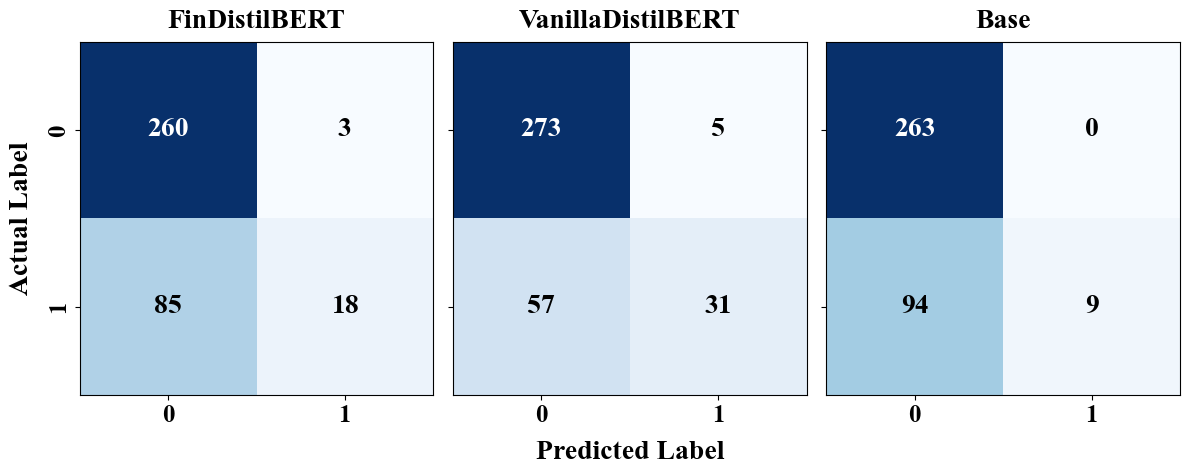

In [42]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Times New Roman'
cm_finbert = metrics_finbert_TSLA["cm"]
cm_distilbert = metrics_distilbert_TSLA["cm"]
cm_base = metrics_base_TSLA["cm"]

# Create a 2x2 subplot
fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True)
# List of confusion matrices and titles
cms = [cm_finbert, cm_distilbert, cm_base]
titles = ['FinDistilBERT','VanillaDistilBERT', 'Base']

for i, ax in enumerate(axes.flatten()):
    im = ax.imshow(cms[i], interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(titles[i], fontweight='bold', fontsize=20, pad = 10)
    if i == 0:
        ax.set_ylabel('Actual Label', fontweight='bold',fontsize=20, labelpad=10)
    if i ==1:
        ax.set_xlabel('Predicted Label', fontweight='bold',fontsize=20, labelpad=10)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['0', '1'], fontweight='bold',fontsize=18)
    ax.set_yticklabels(['0', '1'], rotation=90, va="center", fontweight='bold',fontsize=18)

    # Loop over data dimensions and create text annotations.
    thresh = cms[i].max() / 2.
    for j in range(cms[i].shape[0]):
        for k in range(cms[i].shape[1]):
            ax.text(k, j, format(cms[i][j, k]),
                    ha="center", va="center",fontweight='bold',fontsize=20,
                    color="white" if cms[i][j, k] > thresh else "black")
plt.tight_layout()
plt.savefig('/Users/alan/Desktop/BI/Thesis/1st_draft/Latex/images/confusion_matrices_stock.pdf', dpi=300)

## Do the Stock Market Prediction

In [5]:
## `tweet_id` stands for the column of id, `post_date` stands for the date, `body` being the actual post
tweets = pd.read_csv("/Users/alan/Desktop/BI/Thesis/1st_draft/Data/company_tweet/Tweet.csv")
tweets['post_date'] = pd.to_datetime(tweets['post_date'], unit='s')

## two columns contained, one being `tweet_id`, corresponding to the same column in the tweets dataframe. Another one is `ticker_symbol`
company_tweets = pd.read_csv("/Users/alan/Desktop/BI/Thesis/1st_draft/Data/company_tweet/Company_Tweet.csv")

In [6]:
tweets_ticker = tweets.merge(company_tweets, on = "tweet_id", how = "left")
tweets_ticker.loc[tweets_ticker["ticker_symbol"] == "GOOGL", "ticker_symbol"] = "GOOG"
tweets_ticker.body = tweets_ticker.body

In [4]:
## split the dataset according to the different tickers
df_aapl = tweets_ticker.loc[tweets_ticker.ticker_symbol == "AAPL"]
df_amzn = tweets_ticker.loc[tweets_ticker.ticker_symbol == "AMZN"]
df_tsla = tweets_ticker.loc[tweets_ticker.ticker_symbol == "TSLA"]
df_msft = tweets_ticker.loc[tweets_ticker.ticker_symbol == "MSFT"]
df_goog = tweets_ticker.loc[tweets_ticker.ticker_symbol == "GOOG"]

In [14]:
tickers = ["AAPL", "AMZN", "TSLA", "MSFT", "GOOG"]
raw = {ticker: tweets_ticker.loc[tweets_ticker.ticker_symbol == ticker][:50]for ticker in tickers}

In [18]:
print(raw["AAPL"].body)

0      lx21 made $10,008  on $AAPL -Check it out! htt...
1      Insanity of today weirdo massive selling. $aap...
4      Swing Trading: Up To 8.91% Return In 14 Days h...
6      Swing Trading: Up To 8.91% Return In 14 Days h...
8      Swing Trading: Up To 8.91% Return In 14 Days h...
10     Swing Trading: Up To 8.91% Return In 14 Days h...
12     Swing Trading: Up To 8.91% Return In 14 Days h...
14     Swing Trading: Up To 8.91% Return In 14 Days h...
16     Swing Trading: Up To 8.91% Return In 14 Days h...
18     $UNP $ORCL $QCOM $MSFT $AAPL Top scoring mega ...
20     $AAPL Apple goes global with 'Start Something ...
21     “@WSJ: Apple is being sued for falsely adverti...
22     Apple filed for its own stylus patent in 2010 ...
23     @CNBC 15 Top #trades for #2015 #FastMoney $TIF...
24     We searched through hundreds of charts and fou...
25     Top 10 searched #stocks of #2014 $AAPL $FB $BA...
29     2014 The Year in Review (Part II - THE END) ht...
31     Give your brain a workou

In [8]:
from utils import preprocess, tokenize, vectorize
import gensim.downloader
embeddings = gensim.downloader.load("word2vec-google-news-300")
embedding = dict()
for company, data in raw.items():
    X = data["body"].to_list()
    vectorised = []
    for tweet in X:
        embedded = vectorize(
                    tweet, embeddings, 64
                )
        vectorised.append(embedded)
    X = vectorised
            # split the data
    X = np.array(X)
    embedding[company] = X

In [13]:
x = np.array([[1,2],[3,4]])
x

array([[1, 2],
       [3, 4]])

In [5]:
from utils import preprocess, tokenize, vectorize
import gensim.downloader
embeddings = gensim.downloader.load("word2vec-google-news-300")
for comnay, data in raw.items():
    break
X = data["body"].to_list()
X = tokenize(X)
vectorised = []
for tweet in X:
    embedded = vectorize(tweet, embeddings, 64)
    vectorised.append(embedded)
    break
vectorised


[[array([-5.59082031e-02,  1.17675781e-01,  2.10937500e-01,  8.36181641e-03,
          7.27539062e-02, -3.12500000e-01, -2.91748047e-02,  1.13677979e-03,
          3.16406250e-01,  7.37304688e-02,  5.12695312e-03, -1.58203125e-01,
         -1.50390625e-01,  2.27539062e-01,  1.03027344e-01, -8.15429688e-02,
          2.46093750e-01,  3.07617188e-02,  4.37011719e-02,  1.78710938e-01,
         -7.22656250e-02,  1.10839844e-01,  7.51953125e-02,  1.25976562e-01,
         -1.10473633e-02, -2.06054688e-01, -2.04101562e-01,  4.12597656e-02,
         -1.35742188e-01,  1.80664062e-01,  1.58203125e-01, -1.23046875e-01,
          1.06201172e-02,  3.78417969e-02,  2.07519531e-02,  1.42669678e-03,
          1.34765625e-01,  6.83593750e-02,  1.04003906e-01, -1.96533203e-02,
          9.37500000e-02, -6.54296875e-02,  1.44531250e-01, -1.14257812e-01,
          2.50000000e-01, -9.03320312e-02, -4.98046875e-02, -4.63867188e-02,
         -2.90527344e-02, -1.84570312e-01,  7.47070312e-02, -4.41894531e-02,

In [15]:
df = pd.read_csv("/Users/alan/Desktop/BI/Thesis/1st_draft/Data/Tweet.csv")
df["post_date"] = pd.to_datetime(df["post_date"], unit = "s")

In [22]:
import importlib
importlib.reload(stockPredictor)
importlib.reload(finDistilBert)
importlib.reload(biLSTM)

NameError: name 'stockPredictor' is not defined

In [12]:
from transformers import DistilBertForMaskedLM
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from transformers import Trainer, TrainingArguments
import torch
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import importlib
import emoji
import re
import finDistilBert
importlib.reload(finDistilBert)
from finDistilBert import *
from biLSTM import BiLSTM
import stockPredictor
importlib.reload(stockPredictor)
from stockPredictor import *
import gensim.downloader
import importlib

current_path = os.getcwd()
data_path = os.path.join(current_path, "Data")
model_path = os.path.join(current_path, "models")
log_path = os.path.join(current_path, "trainingLog")
distilbert_mask = DistilBertForMaskedLM.from_pretrained("distilbert-base-uncased")

config = Config(
    data_dir=data_path,
    distilbert_mask=distilbert_mask,
    model_dir=model_path,
    log_dir=log_path,
)

embeddings = gensim.downloader.load("word2vec-google-news-300")

# classifier = BiLSTM(
#     max_sequence_length=64,
#     embedding_model=embeddings,
#     data_dir=data_path,
#     seed=42,
#     embedding_dim=300,
#     nepoch=6,
# )
# tickers=["AAPL", "AMZN", "TSLA", "MSFT", "GOOG"],


config_predictor = Config_Stock(
    data_dir=data_path, model_dir=model_path, embedding_model=embeddings, lr_start=5e-4,lr_end=5e-5, training_epochs = 15
)

predictor = StockPredictor(config=config_predictor)
history = predictor.train(engine="finbert",ticker="AAPL")

Some layers from the model checkpoint at /Users/alan/Desktop/BI/Thesis/1st_draft/models/FurtherTrain+FineTune were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /Users/alan/Desktop/BI/Thesis/1st_draft/models/FurtherTrain+FineTune and are newly initialized: ['dropout_347']
You should probably TRAIN this model on a down-stream task to be able to use it 

1/1 [==============================] - 1s 1s/step


Epoch 1/15
34/34 [==============================] - 3s 34ms/step - loss: 0.6054 - accuracy: 0.7317 - precision_4: 0.1053 - val_loss: 0.6912 - val_accuracy: 0.6393 - val_precision_4: 0.0000e+00
Epoch 2/15
34/34 [==============================] - 1s 23ms/step - loss: 0.5768 - accuracy: 0.7458 - precision_4: 0.0000e+00 - val_loss: 0.6932 - val_accuracy: 0.6393 - val_precision_4: 0.0000e+00
Epoch 3/15
34/34 [==============================] - 1s 24ms/step - loss: 0.5709 - accuracy: 0.7458 - precision_4: 0.0000e+00 - val_loss: 0.6800 - val_accuracy: 0.6393 - val_precision_4: 0.0000e+00
Epoch 4/15
34/34 [==============================] - 1s 24ms/step - loss: 0.5763 - accuracy: 0.7458 - precision_4: 0.0000e+00 - val_loss: 0.6969 - val_accuracy: 0.6393 - val_precision_4: 0.0000e+00
Epoch 5/15
34/34 [==============================] - 1s 24ms/step - loss: 0.5671 - accuracy: 0.7458 - precision_4: 0.0000e+00 - val_loss: 0.6826 - val_accuracy: 0.6393 - val_precision_4: 0.0000e+00
Epoch 6/15
34/34 [=

In [14]:
metrics= predictor.evaluate(engine="finbert",ticker="AAPL")

Some layers from the model checkpoint at /Users/alan/Desktop/BI/Thesis/1st_draft/models/FurtherTrain+FineTune were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /Users/alan/Desktop/BI/Thesis/1st_draft/models/FurtherTrain+FineTune and are newly initialized: ['dropout_429']
You should probably TRAIN this model on a down-stream task to be able to use it 

12/12 [==============================] - 0s 6ms/step


In [15]:
metrics

{'loss': 0.43294525,
 'accuracy': 0.9016393442622951,
 'precision': 1.0,
 'cm': array([[318,   0],
        [ 36,  12]]),
 'f1': 0.4}

In [21]:
from utils import preprocess
import pandas as pd
tweets = pd.read_csv("/Users/alan/Desktop/BI/Thesis/1st_draft/Data/Tweet.csv")

In [25]:
tweets = tweets.dropna(subset = ["body"])

In [27]:
tweets.isna().sum()

Unnamed: 0         0
tweet_id           0
writer         47259
post_date          0
body               0
comment_num        0
retweet_num        0
like_num           0
dtype: int64

In [7]:
df = pd.read_csv("/Users/alan/Desktop/BI/Thesis/1st_draft/Data/CompanyValues.csv", parse_dates=["day_date"])
df.head()

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value
0,AAPL,2020-05-29,317.94,38399530,319.25,321.15,316.47
1,AAPL,2020-05-28,318.25,33449100,316.77,323.44,315.63
2,AAPL,2020-05-27,318.11,28236270,316.14,318.71,313.09
3,AAPL,2020-05-26,316.73,31380450,323.50,324.24,316.50
4,AAPL,2020-05-22,318.89,20450750,315.77,319.23,315.35


In [11]:
df.loc[df["ticker_symbol"] == "AAPL"].sort_values(by = "day_date").head(30)

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value
2516,AAPL,2010-06-01,37.2614,218455576,37.0986,37.9914,36.9943
2515,AAPL,2010-06-02,37.7071,171594061,37.7914,37.8286,37.1907
2514,AAPL,2010-06-03,37.5886,162341809,37.8828,37.9357,37.2014
2513,AAPL,2010-06-04,36.5664,189045767,36.8871,37.4143,36.3757
2512,AAPL,2010-06-07,35.8486,221253336,36.8986,37.0214,35.7928
2511,AAPL,2010-06-08,35.6186,249904415,36.1771,36.2571,35.0928
2510,AAPL,2010-06-09,34.7428,213040094,35.9243,35.9857,34.6414
2509,AAPL,2010-06-10,35.7871,193507918,34.9771,35.8543,34.6000
2508,AAPL,2010-06-11,36.2157,136154451,35.4607,36.2657,35.3386
2507,AAPL,2010-06-14,36.3257,150469315,36.5657,37.0214,36.2871


In [2]:
from transformers import DistilBertForMaskedLM
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from transformers import Trainer, TrainingArguments
import torch
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import emoji
import re
import os
from finDistilBert import *
from biLSTM import *
from stockPredictor import *
import gensim.downloader

current_path = os.getcwd()
data_path = os.path.join(current_path, "Data")
model_path = os.path.join(current_path, "models")
log_path = os.path.join(current_path, "trainingLog")
distilbert_mask = DistilBertForMaskedLM.from_pretrained("distilbert-base-uncased")

config = Config(
    data_dir=data_path,
    distilbert_mask=distilbert_mask,
    model_dir=model_path,
    log_dir=log_path,
    gradual_unfreeze=False
)

In [6]:
## config and read / format dataset
embeddings = gensim.downloader.load("word2vec-google-news-300")

path_tweets = os.path.join(config.data_dir, "Tweet.csv")
path_companyTweets = os.path.join(config.data_dir, "Company_Tweet.csv")
tweets = pd.read_csv(path_tweets)
tweets["post_date"] = pd.to_datetime(tweets["post_date"], unit="s")
tweets["post_date"] = tweets["post_date"].dt.strftime("%Y-%m-%d")
company_tweets = pd.read_csv(path_companyTweets)


path_stock = os.path.join(config.data_dir, "CompanyValues.csv")
stocks = pd.read_csv(path_stock)
stocks["day_date"] = pd.to_datetime(stocks["day_date"], format="%Y-%m-%d")
stocks.loc[stocks["ticker_symbol"] == "GOOGL", "ticker_symbol"] = "GOOG"

## Prepare the data for backtesting

In [ ]:
import os
current_path = os.getcwd()
data_path = os.path.join(current_path, "Data")
finbert_path = os.path.join(data_path, "FinDistilBERT_bt")
distilbert_path = os.path.join(data_path, "DistilBERT_bt")
os.makedirs(finbert_path,exist_ok=True)
os.makedirs(distilbert_path,exist_ok=True)

In [9]:
import pickle
from datetime import datetime

with open('pickles/predictions_distilbert_AAPL.pickle', 'rb') as file:
    pred_distil_AAPL = pickle.load(file)
    
with open('pickles/predictions_distilbert_AMZN.pickle', 'rb') as file:
    pred_distil_AMZN = pickle.load(file)
    
with open('pickles/predictions_distilbert_GOOG.pickle', 'rb') as file:
    pred_distil_GOOG = pickle.load(file)
    
with open('pickles/predictions_distilbert_MSFT.pickle', 'rb') as file:
    pred_distil_MSFT = pickle.load(file)
    
with open('pickles/predictions_distilbert_TSLA.pickle', 'rb') as file:
    pred_distil_TSLA = pickle.load(file)
    
with open('pickles/predictions_finbert_AAPL.pickle', 'rb') as file:
    pred_fin_AAPL = pickle.load(file)
    
with open('pickles/predictions_finbert_AMZN.pickle', 'rb') as file:
    pred_fin_AMZN = pickle.load(file)
    
with open('pickles/predictions_finbert_GOOG.pickle', 'rb') as file:
    pred_fin_GOOG = pickle.load(file)
    
with open('pickles/predictions_finbert_MSFT.pickle', 'rb') as file:
    pred_fin_MSFT = pickle.load(file)
    
with open('pickles/predictions_finbert_TSLA.pickle', 'rb') as file:
    pred_fin_TSLA = pickle.load(file)
    
############################################    
with open('pickles/predictions_base_AAPL.pickle', 'rb') as file:
    pred_base_AAPL = pickle.load(file)
    
with open('pickles/predictions_base_AMZN.pickle', 'rb') as file:
    pred_base_AMZN = pickle.load(file)
    
with open('pickles/predictions_base_GOOG.pickle', 'rb') as file:
    pred_base_GOOG = pickle.load(file)
    
with open('pickles/predictions_base_MSFT.pickle', 'rb') as file:
    pred_base_MSFT = pickle.load(file)
    
with open('pickles/predictions_base_TSLA.pickle', 'rb') as file:
    pred_base_TSLA = pickle.load(file)

In [13]:
pd.Series(pred_base_AMZN.reshape(-1,)).value_counts()

0    366
Name: count, dtype: int64

### DistilBERT

In [3]:
predictions_distilbert = {
    "AAPL": pred_distil_AAPL,
    "AMZN": pred_distil_AMZN,
    "GOOG": pred_distil_GOOG,
    "MSFT": pred_distil_MSFT,
    "TSLA": pred_distil_TSLA
}

distilbert_bt = dict()
tickers = ["AAPL", "AMZN", "GOOG", "MSFT", "TSLA"]

In [10]:
for ticker in tickers:
    df = pd.read_csv("Data/CompanyValues.csv", parse_dates=["day_date"])
    df = df.loc[df.ticker_symbol == ticker].sort_values(by = "day_date").loc[(df["day_date"] >= datetime(2018, 12, 31)) & (df["day_date"] <= datetime(2019, 12, 31))].reset_index(drop = True)
    df["openinterest"] = 0
    df["signal"] = predictions_distilbert[ticker]

    df.rename(columns={'ticker_symbol': 'code', 'day_date': 'date', 'open_value': 'open', 'high_value': 'high', 'low_value': 'low', 'close_value': 'close'}, inplace=True)
    df.set_index("date", inplace=True)
    distilbert_bt[ticker] = df

In [11]:
with open('pickles/distilbert_bt.pickle', 'wb') as file:
    pickle.dump(distilbert_bt, file)

### FinDistilBERT

In [8]:
predictions_finbert = {
    "AAPL": pred_fin_AAPL,
    "AMZN": pred_fin_AMZN,
    "GOOG": pred_fin_GOOG,
    "MSFT": pred_fin_MSFT,
    "TSLA": pred_fin_TSLA
}

finbert_bt = dict()
tickers = ["AAPL", "AMZN", "GOOG", "MSFT", "TSLA"]

In [9]:
for ticker in tickers:
    df = pd.read_csv("Data/CompanyValues.csv", parse_dates=["day_date"])
    df = df.loc[df.ticker_symbol == ticker].sort_values(by = "day_date").loc[(df["day_date"] >= datetime(2018, 12, 31)) & (df["day_date"] <= datetime(2019, 12, 31))].reset_index(drop = True)
    df["openinterest"] = 0
    df["signal"] = predictions_finbert[ticker]

    df.rename(columns={'ticker_symbol': 'code', 'day_date': 'date', 'open_value': 'open', 'high_value': 'high', 'low_value': 'low', 'close_value': 'close'}, inplace=True)
    df.set_index("date", inplace=True)
    finbert_bt[ticker] = df

In [190]:
with open('pickles/finbert_bt.pickle', 'wb') as file:
    pickle.dump(finbert_bt, file)

### Base

In [1]:
predictions_base = {
    "AAPL": pred_base_AAPL,
    "AMZN": pred_base_AMZN,
    "GOOG": pred_base_GOOG,
    "MSFT": pred_base_MSFT,
    "TSLA": pred_base_TSLA
}
base_bt = dict()
tickers = ["AAPL", "AMZN", "GOOG", "MSFT", "TSLA"]

NameError: name 'pred_base_AAPL' is not defined

In [58]:
for ticker in tickers:
    df = pd.read_csv("Data/CompanyValues.csv", parse_dates=["day_date"])
    df = df.loc[df.ticker_symbol == ticker].sort_values(by = "day_date").loc[(df["day_date"] >= datetime(2018, 12, 31)) & (df["day_date"] <= datetime(2019, 12, 31))].reset_index(drop = True)
    df["openinterest"] = 0
    df["signal"] = predictions_base[ticker]

    df.rename(columns={'ticker_symbol': 'code', 'day_date': 'date', 'open_value': 'open', 'high_value': 'high', 'low_value': 'low', 'close_value': 'close'}, inplace=True)
    df.set_index("date", inplace=True)
    base_bt[ticker] = df

In [59]:
with open('pickles/base_bt.pickle', 'wb') as file:
    pickle.dump(base_bt, file)

In [1]:
## import the necessary libraries
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.optimize as opt
import statsmodels.api as sm
import scipy.stats as stats
import pandas as pd
import numpy as np
from datetime import datetime
import qstock as qs
import backtrader as bt
import pickle
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']  # Choose a font available on your system
plt.rcParams['axes.unicode_minus'] = False

## import the data reading method
from load_data import pandasData

## import the aimed strategy
from strategy import TestStrategy

## read the data

with open("pickles/finbert_bt.pickle", "rb") as file:
    datas = pickle.load(file)

cerebro = bt.Cerebro()

for stock_name, df in datas.items():
    data = pandasData(dataname=df)
    cerebro.adddata(data, name=stock_name)
# # # 将交易策略加载到回测系统中
cerebro.addstrategy(TestStrategy)

# # # cerebro.optstrategy(TestStrategy, maperiod=range(10, 31))

cerebro.broker.set_cash(100000)
cerebro.broker.setcommission(commission=0.002)

# # # print the starting point
cerebro.run()

cerebro.plot()

2019-12-31, The ending value is 127526.05887800003.


<IPython.core.display.Javascript object>

[[<Figure size 640x480 with 12 Axes>]]

In [2]:
from transformers import DistilBertForMaskedLM
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from transformers import Trainer, TrainingArguments
import torch
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import emoji
import re
import os
from finDistilBert import *
from biLSTM import *
from stockPredictor import *
import gensim.downloader

current_path = os.getcwd()
data_path = os.path.join(current_path, "Data")
model_path = os.path.join(current_path, "models")
log_path = os.path.join(current_path, "trainingLog")
distilbert_mask = DistilBertForMaskedLM.from_pretrained("distilbert-base-uncased")

config = Config(
    data_dir=data_path,
    distilbert_mask=distilbert_mask,
    model_dir=model_path,
    log_dir=log_path,
    gradual_unfreeze=False
)

In [3]:
## config and read / format dataset
embeddings = gensim.downloader.load("word2vec-google-news-300")

path_tweets = os.path.join(config.data_dir, "Tweet.csv")
path_companyTweets = os.path.join(config.data_dir, "Company_Tweet.csv")
tweets = pd.read_csv(path_tweets)
tweets["post_date"] = pd.to_datetime(tweets["post_date"], unit="s")
tweets["post_date"] = tweets["post_date"].dt.strftime("%Y-%m-%d")
company_tweets = pd.read_csv(path_companyTweets)


path_stock = os.path.join(config.data_dir, "CompanyValues.csv")
stocks = pd.read_csv(path_stock)
stocks["day_date"] = pd.to_datetime(stocks["day_date"], format="%Y-%m-%d")
stocks = stocks.loc[stocks["ticker_symbol"] != "GOOGL"]

In [4]:
# AAPL
### do the configuration
config_predictor = Config_Stock(
    data_dir=data_path,
    model_dir=model_path,
    embedding_model=embeddings,
)

predictor_AAPL = StockPredictor(
    config=config_predictor, tweets=tweets, company_tweets=company_tweets, stocks=stocks
)

### get data
train_dataset, valid_dataset, test_dataset = predictor_AAPL.prepare_data_for_LSTM(engine = "distilbert", ticker = "AAPL", baseline = True)

In [7]:
### train the model
history = predictor_AAPL.train(engine="distilbert",
                          ticker="AAPL",
                          train_dataset = train_dataset,
                          valid_dataset = valid_dataset,
                          lr_start=5e-3,
                          lr_end=4e-3,training_epochs=15)

Epoch 1/15
34/34 [==============================] - 3s 42ms/step - loss: 0.5413 - accuracy: 0.7749 - precision_1: 0.0769 - val_loss: 0.5116 - val_accuracy: 0.7951 - val_precision_1: 0.0000e+00
Epoch 2/15
34/34 [==============================] - 1s 32ms/step - loss: 0.5234 - accuracy: 0.7852 - precision_1: 0.0000e+00 - val_loss: 0.5157 - val_accuracy: 0.7951 - val_precision_1: 0.0000e+00
Epoch 3/15
34/34 [==============================] - 1s 32ms/step - loss: 0.5129 - accuracy: 0.7852 - precision_1: 0.0000e+00 - val_loss: 0.5028 - val_accuracy: 0.7951 - val_precision_1: 0.0000e+00
Epoch 4/15
34/34 [==============================] - 1s 34ms/step - loss: 0.4964 - accuracy: 0.7852 - precision_1: 0.0000e+00 - val_loss: 0.6065 - val_accuracy: 0.7951 - val_precision_1: 0.0000e+00
Epoch 5/15
34/34 [==============================] - 1s 33ms/step - loss: 0.4958 - accuracy: 0.7852 - precision_1: 0.0000e+00 - val_loss: 0.5691 - val_accuracy: 0.7951 - val_precision_1: 0.0000e+00
Epoch 6/15
34/34 [=

In [8]:
### do the evaluation
metrics_base_AAPL, predictions_base_AAPL = predictor_AAPL.evaluate(engine="distilbert",
                                                                    ticker="AAPL",
                                                                    test_dataset = test_dataset)

metrics_base_AAPL

12/12 [==============================] - 0s 8ms/step


{'loss': 1.3953421,
 'accuracy': 0.7131147540983607,
 'precision': 0.9210526315789473,
 'cm': array([[226,   3],
        [102,  35]]),
 'f1': 0.4}

In [66]:
### save the results
import pickle
with open('/Users/alan/Desktop/BI/Thesis/1st_draft/pickles/predictions_base_AAPL.pickle', 'wb') as f:
    pickle.dump(predictions_base_AAPL, f)

with open('/Users/alan/Desktop/BI/Thesis/1st_draft/pickles/metrics_base_AAPL.pickle', 'wb') as f:
    pickle.dump(metrics_base_AAPL, f)

with open('/Users/alan/Desktop/BI/Thesis/1st_draft/pickles/history_base_AAPL.pickle', 'wb') as f:
    pickle.dump(history, f)

In [33]:
# AMZN
### do the configuration
config_predictor = Config_Stock(
    data_dir=data_path,
    model_dir=model_path,
    embedding_model=embeddings,
)

predictor_AMZN = StockPredictor(
    config=config_predictor, tweets=tweets, company_tweets=company_tweets, stocks=stocks
)

### get data
train_dataset, valid_dataset, test_dataset = predictor_AMZN.prepare_data_for_LSTM(engine = "distilbert", ticker = "AMZN", baseline = True)

In [36]:
### train the model
history = predictor_AMZN.train(engine="distilbert",
                          ticker="AMZN",
                          train_dataset = train_dataset,
                          valid_dataset = valid_dataset,
                          lr_start=5e-3,
                          lr_end=4e-3,training_epochs=20)

Epoch 1/20
34/34 [==============================] - 3s 37ms/step - loss: 0.5748 - accuracy: 0.7542 - precision_9: 0.0000e+00 - val_loss: 0.6333 - val_accuracy: 0.6858 - val_precision_9: 0.0000e+00
Epoch 2/20
34/34 [==============================] - 1s 30ms/step - loss: 0.5655 - accuracy: 0.7542 - precision_9: 0.0000e+00 - val_loss: 0.6418 - val_accuracy: 0.6858 - val_precision_9: 0.0000e+00
Epoch 3/20
34/34 [==============================] - 1s 31ms/step - loss: 0.5566 - accuracy: 0.7542 - precision_9: 0.0000e+00 - val_loss: 0.6298 - val_accuracy: 0.6858 - val_precision_9: 0.0000e+00
Epoch 4/20
34/34 [==============================] - 1s 30ms/step - loss: 0.5562 - accuracy: 0.7542 - precision_9: 0.0000e+00 - val_loss: 0.7398 - val_accuracy: 0.6858 - val_precision_9: 0.0000e+00
Epoch 5/20
34/34 [==============================] - 1s 30ms/step - loss: 0.5653 - accuracy: 0.7533 - precision_9: 0.0000e+00 - val_loss: 0.6656 - val_accuracy: 0.6858 - val_precision_9: 0.0000e+00
Epoch 6/20
34/3

In [35]:
### do the evaluation
metrics_base_AMZN, predictions_base_AMZN = predictor_AMZN.evaluate(engine="distilbert",
                                                                    ticker="AMZN",
                                                                    test_dataset = test_dataset)

metrics_base_AMZN

12/12 [==============================] - 0s 6ms/step


{'loss': 0.5803172,
 'accuracy': 0.8797814207650273,
 'precision': 0.8636363636363636,
 'cm': array([[303,   3],
        [ 41,  19]]),
 'f1': 0.46341463414634154}

In [76]:
### save the results
import pickle
with open('/Users/alan/Desktop/BI/Thesis/1st_draft/pickles/predictions_base_AMZN.pickle', 'wb') as f:
    pickle.dump(predictions_base_AMZN, f)

with open('/Users/alan/Desktop/BI/Thesis/1st_draft/pickles/metrics_base_AMZN.pickle', 'wb') as f:
    pickle.dump(metrics_base_AMZN, f)

with open('/Users/alan/Desktop/BI/Thesis/1st_draft/pickles/history_base_AMZN.pickle', 'wb') as f:
    pickle.dump(history, f)

In [77]:
# TSLA
### do the configuration
config_predictor = Config_Stock(
    data_dir=data_path,
    model_dir=model_path,
    embedding_model=embeddings,
)

predictor_TSLA = StockPredictor(
    config=config_predictor, tweets=tweets, company_tweets=company_tweets, stocks=stocks
)

### get data
train_dataset, valid_dataset, test_dataset = predictor_TSLA.prepare_data_for_LSTM(engine = "distilbert", ticker = "TSLA", baseline = True)

In [78]:
### train the model
history = predictor_TSLA.train(engine="distilbert",
                          ticker="TSLA",
                          train_dataset = train_dataset,
                          valid_dataset = valid_dataset,
                          lr_start=5e-3,
                          lr_end=4e-3,training_epochs=15)

Epoch 1/15
34/34 [==============================] - 3s 37ms/step - loss: 0.5563 - accuracy: 0.7636 - precision_24: 1.0000 - val_loss: 0.5735 - val_accuracy: 0.7760 - val_precision_24: 0.0000e+00
Epoch 2/15
34/34 [==============================] - 1s 26ms/step - loss: 0.5197 - accuracy: 0.7805 - precision_24: 0.7049 - val_loss: 0.5321 - val_accuracy: 0.7760 - val_precision_24: 0.0000e+00
Epoch 3/15
34/34 [==============================] - 1s 26ms/step - loss: 0.5292 - accuracy: 0.7824 - precision_24: 0.7547 - val_loss: 0.5213 - val_accuracy: 0.7760 - val_precision_24: 0.0000e+00
Epoch 4/15
34/34 [==============================] - 1s 26ms/step - loss: 0.5318 - accuracy: 0.7749 - precision_24: 1.0000 - val_loss: 0.5175 - val_accuracy: 0.7760 - val_precision_24: 0.0000e+00
Epoch 5/15
34/34 [==============================] - 1s 27ms/step - loss: 0.5071 - accuracy: 0.7852 - precision_24: 0.9412 - val_loss: 0.5202 - val_accuracy: 0.7760 - val_precision_24: 0.0000e+00
Epoch 6/15
34/34 [=======

In [79]:
### do the evaluation
metrics_base_TSLA, predictions_base_TSLA = predictor_TSLA.evaluate(engine="distilbert",
                                                                    ticker="AMZN",
                                                                    test_dataset = test_dataset)

metrics_base_TSLA

12/12 [==============================] - 0s 7ms/step


{'loss': 1.1854277,
 'accuracy': 0.7431693989071039,
 'precision': 1.0,
 'cm': array([[263,   0],
        [ 94,   9]]),
 'f1': 0.16071428571428573}

In [80]:
### save the results
import pickle
with open('/Users/alan/Desktop/BI/Thesis/1st_draft/pickles/predictions_base_TSLA.pickle', 'wb') as f:
    pickle.dump(predictions_base_TSLA, f)

with open('/Users/alan/Desktop/BI/Thesis/1st_draft/pickles/metrics_base_TSLA.pickle', 'wb') as f:
    pickle.dump(metrics_base_TSLA, f)

with open('/Users/alan/Desktop/BI/Thesis/1st_draft/pickles/history_base_TSLA.pickle', 'wb') as f:
    pickle.dump(history, f)

In [81]:
# GOOG
### do the configuration
config_predictor = Config_Stock(
    data_dir=data_path,
    model_dir=model_path,
    embedding_model=embeddings,
)

predictor_GOOG = StockPredictor(
    config=config_predictor, tweets=tweets, company_tweets=company_tweets, stocks=stocks
)

### get data
train_dataset, valid_dataset, test_dataset = predictor_GOOG.prepare_data_for_LSTM(engine = "distilbert", ticker = "GOOG", baseline = True)

In [82]:
### train the model
history = predictor_GOOG.train(engine="distilbert",
                          ticker="GOOG",
                          train_dataset = train_dataset,
                          valid_dataset = valid_dataset,
                          lr_start=5e-3,
                          lr_end=4e-3,training_epochs=15)

Epoch 1/15
34/34 [==============================] - 3s 38ms/step - loss: 0.5506 - accuracy: 0.7561 - precision_25: 0.1429 - val_loss: 0.6593 - val_accuracy: 0.7022 - val_precision_25: 0.0000e+00
Epoch 2/15
34/34 [==============================] - 1s 27ms/step - loss: 0.5461 - accuracy: 0.7702 - precision_25: 0.0000e+00 - val_loss: 0.6144 - val_accuracy: 0.7022 - val_precision_25: 0.0000e+00
Epoch 3/15
34/34 [==============================] - 1s 28ms/step - loss: 0.5424 - accuracy: 0.7702 - precision_25: 0.0000e+00 - val_loss: 0.6341 - val_accuracy: 0.7022 - val_precision_25: 0.0000e+00
Epoch 4/15
34/34 [==============================] - 1s 28ms/step - loss: 0.5484 - accuracy: 0.7702 - precision_25: 0.0000e+00 - val_loss: 0.6368 - val_accuracy: 0.7022 - val_precision_25: 0.0000e+00
Epoch 5/15
34/34 [==============================] - 1s 28ms/step - loss: 0.5446 - accuracy: 0.7702 - precision_25: 0.0000e+00 - val_loss: 0.6187 - val_accuracy: 0.7022 - val_precision_25: 0.0000e+00
Epoch 6/1

In [83]:
### do the evaluation
metrics_base_GOOG, predictions_base_GOOG = predictor_GOOG.evaluate(engine="distilbert",
                                                                    ticker="GOOG",
                                                                    test_dataset = test_dataset)

metrics_base_GOOG

12/12 [==============================] - 0s 8ms/step


{'loss': 0.6903803,
 'accuracy': 0.76775956284153,
 'precision': 0.7692307692307693,
 'cm': array([[271,   3],
        [ 82,  10]]),
 'f1': 0.19047619047619047}

In [84]:
### save the results
import pickle
with open('/Users/alan/Desktop/BI/Thesis/1st_draft/pickles/predictions_base_GOOG.pickle', 'wb') as f:
    pickle.dump(predictions_base_GOOG, f)

with open('/Users/alan/Desktop/BI/Thesis/1st_draft/pickles/metrics_base_GOOG.pickle', 'wb') as f:
    pickle.dump(metrics_base_GOOG, f)

with open('/Users/alan/Desktop/BI/Thesis/1st_draft/pickles/history_base_GOOG.pickle', 'wb') as f:
    pickle.dump(history, f)

In [85]:
# MSFT
### do the configuration
config_predictor = Config_Stock(
    data_dir=data_path,
    model_dir=model_path,
    embedding_model=embeddings,
)

predictor_MSFT = StockPredictor(
    config=config_predictor, tweets=tweets, company_tweets=company_tweets, stocks=stocks
)

### get data
train_dataset, valid_dataset, test_dataset = predictor_MSFT.prepare_data_for_LSTM(engine = "distilbert", ticker = "MSFT", baseline = True)

In [86]:
### train the model
history = predictor_MSFT.train(engine="distilbert",
                          ticker="MSFT",
                          train_dataset = train_dataset,
                          valid_dataset = valid_dataset,
                          lr_start=5e-3,
                          lr_end=4e-3,training_epochs=15)

Epoch 1/15
34/34 [==============================] - 3s 34ms/step - loss: 0.5672 - accuracy: 0.7617 - precision_26: 0.2308 - val_loss: 0.6599 - val_accuracy: 0.7213 - val_precision_26: 0.0000e+00
Epoch 2/15
34/34 [==============================] - 1s 23ms/step - loss: 0.5423 - accuracy: 0.7683 - precision_26: 0.0000e+00 - val_loss: 0.6162 - val_accuracy: 0.7213 - val_precision_26: 0.0000e+00
Epoch 3/15
34/34 [==============================] - 1s 25ms/step - loss: 0.5363 - accuracy: 0.7655 - precision_26: 0.0000e+00 - val_loss: 0.6574 - val_accuracy: 0.7213 - val_precision_26: 0.0000e+00
Epoch 4/15
34/34 [==============================] - 1s 24ms/step - loss: 0.5339 - accuracy: 0.7683 - precision_26: 0.0000e+00 - val_loss: 0.5928 - val_accuracy: 0.7213 - val_precision_26: 0.0000e+00
Epoch 5/15
34/34 [==============================] - 1s 24ms/step - loss: 0.5255 - accuracy: 0.7683 - precision_26: 0.5000 - val_loss: 0.5815 - val_accuracy: 0.7213 - val_precision_26: 0.0000e+00
Epoch 6/15
34

In [87]:
### do the evaluation
metrics_base_MSFT, predictions_base_MSFT = predictor_MSFT.evaluate(engine="distilbert",
                                                                    ticker="MSFT",
                                                                    test_dataset = test_dataset)

metrics_base_MSFT

12/12 [==============================] - 0s 6ms/step


{'loss': 0.8047834,
 'accuracy': 0.7786885245901639,
 'precision': 0.92,
 'cm': array([[262,   2],
        [ 79,  23]]),
 'f1': 0.36220472440944884}

In [53]:
### save the results
import pickle
with open('/Users/alan/Desktop/BI/Thesis/1st_draft/pickles/predictions_base_MSFT.pickle', 'wb') as f:
    pickle.dump(predictions_base_MSFT, f)

with open('/Users/alan/Desktop/BI/Thesis/1st_draft/pickles/metrics_base_MSFT.pickle', 'wb') as f:
    pickle.dump(metrics_base_MSFT, f)

with open('/Users/alan/Desktop/BI/Thesis/1st_draft/pickles/history_base_MSFT.pickle', 'wb') as f:
    pickle.dump(history, f)